### Import data

In [ ]:
import pandas as pd
import numpy as np
from scipy import signal
import soundfile as sf
import librosa
from sklearn.preprocessing import StandardScaler

import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from scipy.stats import chi2

import sys
import os
sys.path.append(os.path.abspath(".."))  # Subir un nivel para encontrar src si está en Isolated_Observations
sys.path.append(os.path.abspath("./src"))  # Alternativamente, busca src en la misma carpeta

from src.data_processing import extract_features
from src.model import scale_features


# Cargar el archivo en un DataFrame
file_path = 'C:/Users/jonat/Desktop/PuertoWilches/MJcodesforCoefficients/features_kyoogu.xlsx'
df = pd.read_excel(file_path)

columns_to_remove = ['Month', 'Day', 'Hour', 'Length', 'Minute', 'Fmin', 'Fmax', 'View', 'Channel']  

# Remove columns from data frame
df = df.drop(columns_to_remove, axis=1, errors='ignore')
df.head()

FS = 48000

## Manual extraction of Spectral Features and concatenation with previous features 

In [3]:
# Calculate features for each segment
# Write the path of the DB
prefix = 'C:/Users/jonat/Desktop/PuertoWilches/Audios/All/'


spectral_features = []
for _, fila in df.iterrows():
    file_path = prefix + fila['File']
    #print(f"Processing file: {file_path}")
    features = extract_features(
        path=file_path,
        start=fila['Start'],
        end=fila['End'],
        freq_range=(fila['FminVoc'], fila['FmaxVoc'])
    )
    spectral_features.append(features)

# Convert the list of dictionaries into a DataFrame
df_spectral_features = pd.DataFrame(spectral_features)

# Crate a copy form the original DataFrame
df_copy = df.copy()

# Concatenate the new DataFrame of Spectral features with the copy of the original one. Index should be reset to avoid problems.
df_copy.reset_index(drop=True, inplace=True)
df_spectral_features.reset_index(drop=True, inplace=True)

df_allFeatures = pd.concat([df_copy, df_spectral_features], axis=1)
# Crear la nueva columna 'Length' como la resta de 'End' menos 'Start'
df_allFeatures['Length'] = df_allFeatures['End'] - df_allFeatures['Start']
df_allFeatures['DeltaFreq'] = df_allFeatures['FmaxVoc'] - df_allFeatures['FminVoc']

df_allFeatures

,File,Specie ID,Start,End,FminVoc,FmaxVoc,Fdom,FCC1,FCC2,FCC3,...,FCC19,FCC20,FCC21,FCC22,FCC23,spectral_centroid,bandwidth,spectral_flatness,Length,DeltaFreq
0,SMA03126_20210611_200000.wav,BOAN,1.2,3.199,1.2,2500,2529.980488,-2.929353,2.864602,-1.819670,...,-0.088081,0.805879,0.583809,-0.054626,0.516533,142.705564,208.074249,0.052909,1.999,2498.8
1,SMA03126_20210611_200000.wav,BOAN,2.0,3.999,2.0,2500,2530.780488,-3.852549,2.218462,-2.664421,...,0.139753,0.489719,-0.282179,-0.593289,-0.227796,148.697025,215.702444,0.056735,1.999,2498.0
2,SMA03126_20210611_200000.wav,BOAN,8.8,10.799,8.8,2500,2537.580488,-2.007076,3.238212,-1.505718,...,-0.019906,0.923981,0.524091,-0.043802,0.336594,170.685233,294.070649,0.064193,1.999,2491.2
3,SMA03126_20210611_200000.wav,BOAN,9.6,11.599,9.6,2500,2538.380488,-1.842339,3.285941,-1.423196,...,-0.357885,0.675144,-0.244911,-0.295990,0.055367,160.675951,259.236291,0.057370,1.999,2490.4
4,SMA03126_20210611_200000.wav,BOAN,12.8,14.799,12.8,2500,2518.165854,-2.599878,1.658349,-2.119815,...,0.038951,-0.581507,-1.090474,-1.311246,-0.667180,155.110997,263.300619,0.060152,1.999,2487.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,SMA03251_20210605_053000.wav,TRGL,54.0,55.999,54.0,7000,7031.560976,-0.029979,2.392827,-2.043617,...,0.316761,-6.490697,-2.456437,1.215712,0.305538,3526.336320,2669.097747,0.165309,1.999,6946.0
1378,SMA03251_20210608_073000.wav,TRGL,10.8,12.799,10.8,7000,7035.190244,1.099034,0.696196,-3.326215,...,0.340347,3.072540,1.381415,-0.477690,-1.625452,3144.172166,2846.429962,0.159697,1.999,6989.2
1379,SMA03251_20210608_073000.wav,TRGL,32.8,34.799,32.8,7000,7033.775610,0.677080,0.964114,-2.265485,...,0.871002,-6.028390,-3.266161,0.114272,1.289721,3801.589040,2041.883464,0.135943,1.999,6967.2
1380,SMA03251_20210608_073000.wav,TRGL,43.6,45.599,43.6,7000,7021.160976,-1.202607,3.951664,-0.532044,...,-0.161219,-2.884795,-1.148504,0.839394,1.333195,3757.645848,2579.497331,0.123812,1.999,6956.4


### Remove noise labels

In [4]:
if 'sonotype' in df_allFeatures.columns:
    df_filtered = df_allFeatures[df_allFeatures['sonotype'] != 'noise']
    print(df_filtered['Specie ID'].value_counts())
else:
    df_filtered = df_allFeatures.dropna(subset=['Specie ID'])
    print(df_filtered['Specie ID'].value_counts())  

Specie ID
BOAN    349
FRAG    325
FUSC    305
PTGN    165
DEND    112
DDPX     76
TRGL     29
MMLS     21
Name: count, dtype: int64


### Divide features and labels, Scale Features

In [7]:
columns_to_remove = ['File','Specie ID','Specie', 'Taxon', 'sonotype', 'Peak Freq']  
df_only_features = df_filtered.drop(columns_to_remove, axis=1, errors='ignore') #Dataframe without labels, only features

# Standardize the features
scaler = StandardScaler()
only_features_scaled = scaler.fit_transform(df_only_features)

### Check Multinormality & Correlation Matrix with spearman

HZResults(hz=5528, pval=0.0, normal=False)


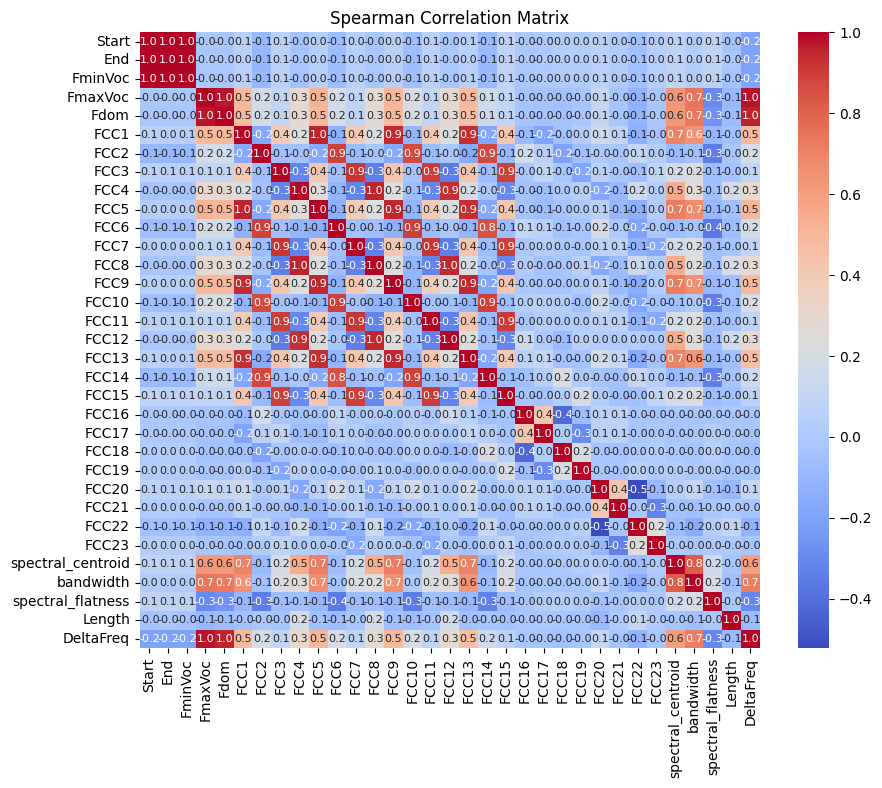

In [8]:
#Normality Test
normality_test = pg.multivariate_normality(only_features_scaled, alpha=0.05)
print(normality_test)

# Convert back to a DataFrame and assign column names
df_only_features_scaled = pd.DataFrame(only_features_scaled, columns=df_only_features.columns)
correlation_matrix = df_only_features_scaled.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", annot_kws={"size": 8})

plt.title('Spearman Correlation Matrix')
plt.show()

## Remove variables with high correlation


In [24]:
# Define the threshold for high correlation
threshold = 0.85

# Create a mask for the upper triangle of the matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Find the variables with high correlation
high_corr_vars = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_vars.add(colname)

#high_corr_vars.add('FCC13')
print("Variables with high correlation:", high_corr_vars)

df_only_features_scaled = df_only_features_scaled.drop(columns=high_corr_vars, errors='ignore')

print(df_only_features_scaled.head())


Variables with high correlation: {'Fdom', 'FCC7', 'FminVoc', 'FCC6', 'FCC13', 'FCC8', 'FCC5', 'FCC9', 'FCC10', 'FCC12', 'FCC15', 'DeltaFreq', 'End', 'FCC14', 'FCC11'}
      Start   FmaxVoc      FCC1      FCC2      FCC3      FCC4     FCC16  \
0 -1.586116 -0.425126 -0.166350 -0.144037  0.032723 -0.519367  0.272913   
1 -1.539569 -0.425126 -0.432345 -0.405437 -0.384320 -0.640918  0.313170   
2 -1.143920 -0.425126  0.099380  0.007108  0.187718 -0.487758 -0.004804   
3 -1.097373 -0.425126  0.146845  0.026417  0.228458 -0.346472 -0.704009   
4 -0.911185 -0.425126 -0.071420 -0.632034 -0.115455 -0.563011  0.219377   

      FCC17     FCC18     FCC19     FCC20     FCC21     FCC22     FCC23  \
0 -0.192648 -0.040908 -0.312766  0.575652  0.913660 -0.243506  0.741152   
1  0.668831  0.261544  0.426223  0.415661 -0.344214 -0.830720 -0.376371   
2  0.759054 -0.266893 -0.091638  0.635417  0.826918 -0.231706  0.470994   
3 -0.995150 -1.234783 -1.187882  0.509494 -0.290080 -0.506625  0.048764   
4  0.14

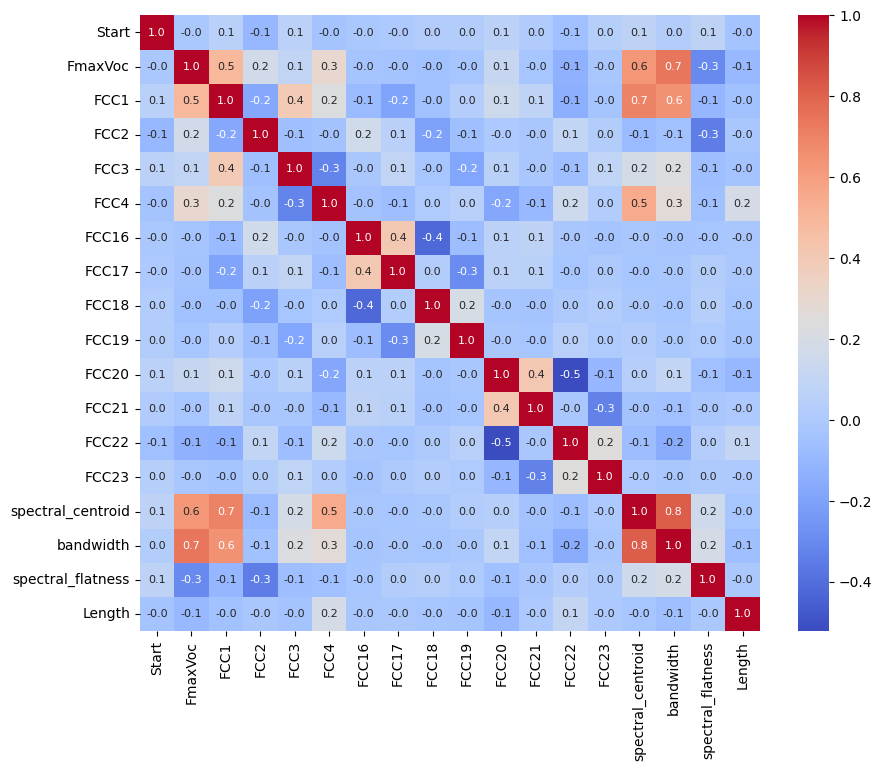

In [27]:
# Display the correlation matrix with a heatmap
plt.figure(figsize=(10, 8))  # Set the size of the figure

# Calculate the correlation matrix using Spearman's method
correlation_matrix_reduced = df_only_features_scaled.corr(method='spearman')

# Generate the heatmap
sns.heatmap(correlation_matrix_reduced, annot=True, cmap='coolwarm', fmt=".1f", annot_kws={"size": 8})

# Show the plot
plt.show()

### Bartlett Test

In [28]:
def self_calculate_bartlett_sphericity(data):
    """
    Perform Bartlett's test of sphericity.
    
    Parameters:
    data : dataframe
        Data frame with scaled features for analysing the Bartlett's test

    Returns:
    chi_square_value : float
        The chi-squared statistic.
    p_value : float
        The associated p-value for the test.
    """

    n_samples = data.shape[0]
    corr_matrix = data.corr(method='spearman')
    # Get the number of variables (p)
    p = corr_matrix.shape[0]
    
    # Calculate the determinant of the correlation matrix
    corr_det = np.linalg.det(corr_matrix)
    
    # Calculate the chi-square statistic using the formula
    statistic = -np.log(corr_det) * (n_samples - 1 - (2 * p + 5) / 6)
    
    # Calculate degrees of freedom
    degrees_of_freedom = p * (p - 1) / 2
    
    # Calculate the p-value from the chi-square distribution
    p_value = chi2.sf(statistic, degrees_of_freedom)
    
    return statistic, p_value



In [29]:
chi_square_value, p_value = self_calculate_bartlett_sphericity(df_only_features_scaled)
print(f"Results of the Bartlett Test are: Chi-square: {chi_square_value}, p-value: {p_value}")

Results of the Bartlett Test are: Chi-square: 9450.28396749934, p-value: 0.0


### KMO Test

KMO: 0.47744786160294833
Global KMO is not adequate: 0.47744786160294833. Variables with value less than 0.4 are removed.
...
...
Detecting variables with low KMO...


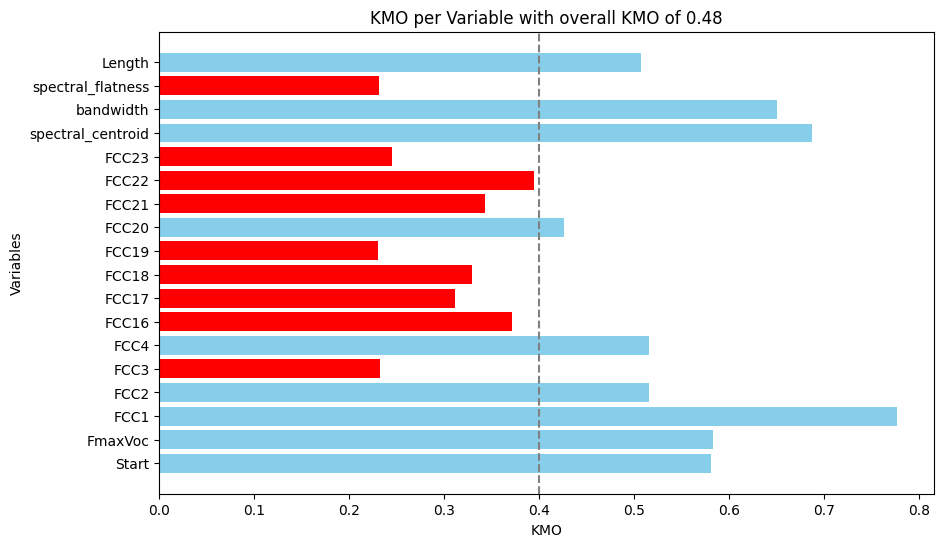

The variables to remove are: 
             Variable
0               FCC3
1              FCC16
2              FCC17
3              FCC18
4              FCC19
5              FCC21
6              FCC22
7              FCC23
8  spectral_flatness
Calculating the new KMO...
The new KMO value after removing variables is: 0.7434638847265224


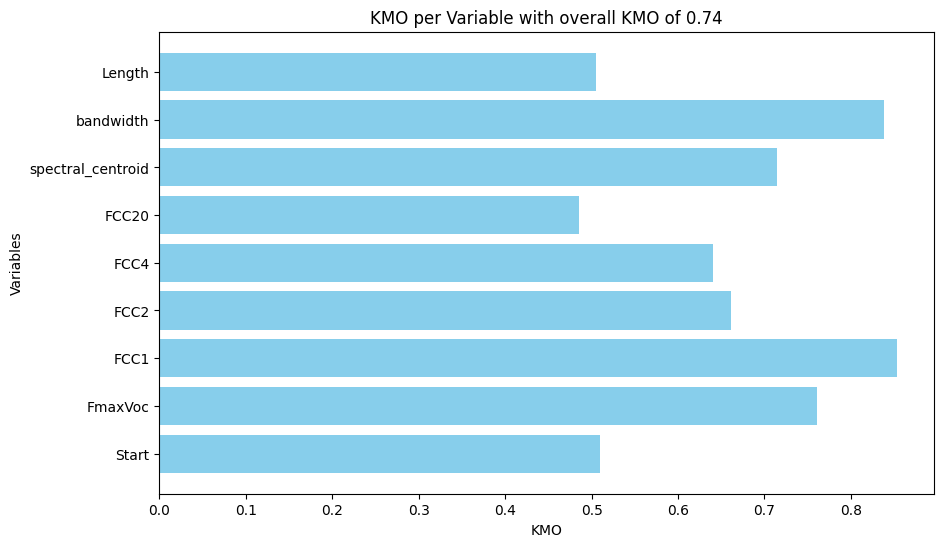

In [31]:
# KMO Test 
kmo_all, kmo_model = calculate_kmo(df_only_features_scaled)
print(f"KMO: {kmo_model}")

# Create a DataFrame with the KMO results for each variable
kmo_df = pd.DataFrame({'Variable': df_only_features_scaled.columns, 'KMO': kmo_all})
variables_to_remove = pd.DataFrame()

while kmo_model < 0.7:
    limit = 0.4
    print(f"Global KMO is not adequate: {kmo_model}. Variables with value less than {limit} are removed.")
    print("...")
    print("...")

    print("Detecting variables with low KMO...")

    # Filter the variables to keep
    variables_to_keep = kmo_df[kmo_df['KMO'] >= limit]['Variable']
    variables_to_remove = pd.concat([variables_to_remove, kmo_df[kmo_df['KMO'] < limit][['Variable']]], ignore_index=True)

    # Create a DataFrame after removing variables with low KMO
    df_filtered_afterKMO = df_only_features_scaled[variables_to_keep]

    # Determine colors for the bars
    colors = ['red' if kmo < limit else 'skyblue' for kmo in kmo_df['KMO']]

    # Visualize the KMO values
    plt.figure(figsize=(10, 6))
    plt.barh(kmo_df['Variable'], kmo_df['KMO'], color=colors)
    plt.xlabel('KMO')
    plt.ylabel('Variables')
    plt.title(f"KMO per Variable with overall KMO of {round(kmo_model, 2)}")
    plt.axvline(x=limit, color='gray', linestyle='--')
    plt.show()
    
    print(f'The variables to remove are: \n {variables_to_remove}')
        
    # Calculate the new KMO
    print("Calculating the new KMO...")
    kmo_all, kmo_model = calculate_kmo(df_filtered_afterKMO)
    kmo_df = pd.DataFrame({'Variable': df_filtered_afterKMO.columns, 'KMO': kmo_all})
    print(f"The new KMO value after removing variables is: {kmo_model}")
    
    if kmo_df[kmo_df['KMO'] < limit]['Variable'].empty:
        break 

# Final visualization of KMO values
plt.figure(figsize=(10, 6))
plt.barh(kmo_df['Variable'], kmo_df['KMO'], color='skyblue')
plt.xlabel('KMO')
plt.ylabel('Variables')
plt.title(f"KMO per Variable with overall KMO of {round(kmo_model, 2)}")
plt.show()


## Estimation of number of factors (Scree plot)

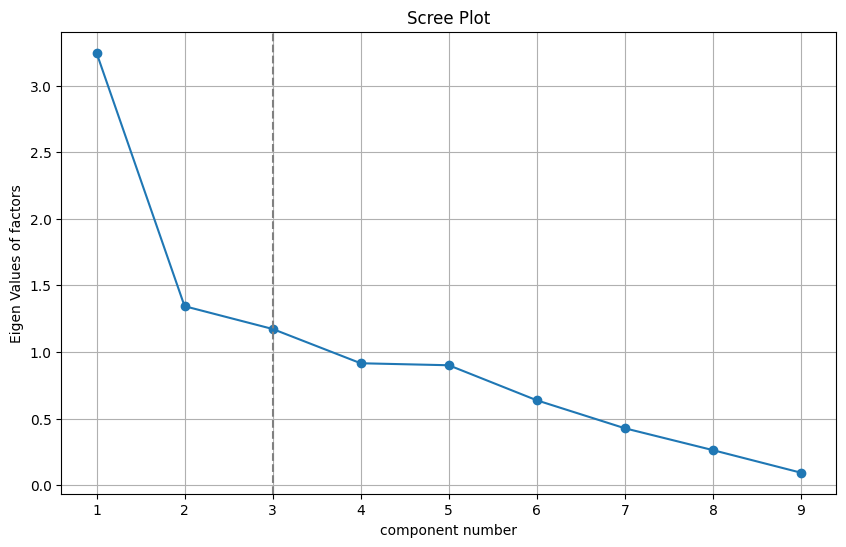

In [34]:
correlation_matrix_afterKMO = df_filtered_afterKMO.corr(method='spearman')
fa = FactorAnalyzer(n_factors=correlation_matrix_afterKMO.shape[1], rotation=None, is_corr_matrix= True)
fa.fit(correlation_matrix_afterKMO)

# Obtain the eigenvalues
ev, v = fa.get_eigenvalues()

# scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, correlation_matrix_afterKMO.shape[1] + 1), ev, marker='o')
plt.xlabel('component number')
plt.ylabel('Eigen Values of factors')
plt.title('Scree Plot')
plt.axvline(x=3, color='gray', linestyle='--')
plt.grid()
plt.show()

## First Factor Analysis with Varimax Rotation

In [35]:
# Factor Analysis with varimax rotation 
fa1 = FactorAnalyzer(n_factors=3, rotation='varimax', method="minres", is_corr_matrix=True)

# Fit the FactorAnalyzer model on the correlation matrix after KMO filtering
# correlation_matrix_afterKMO = df_filtered_afterKMO.corr(method='spearman')
fa1.fit(correlation_matrix_afterKMO)

# Obtain loadings
loadings = fa1.loadings_

# Create a DataFrame with the factor loadings
loadings_df = pd.DataFrame(loadings, columns=[f'Factor{i+1}' for i in range(loadings.shape[1])], index=df_filtered_afterKMO.columns)

print("Factor loadings:")
print(loadings_df)


Factor loadings:
                    Factor1   Factor2   Factor3
Start              0.031422 -0.066704 -0.164639
FmaxVoc            0.819819 -0.142924  0.335319
FCC1               0.703900 -0.107534 -0.319133
FCC2              -0.009686 -0.060761  0.507509
FCC4               0.463786  0.778348  0.036846
FCC20              0.093714 -0.301230 -0.055923
spectral_centroid  0.916329  0.159302 -0.200514
bandwidth          0.886542 -0.150647 -0.063066
Length            -0.049521  0.271283 -0.005336


### Create Latent Variables

In [39]:
# Assign each variable to the factor with the highest loading
assignment = {}
for variable in loadings_df.index:
    max_loading_factor = loadings_df.loc[variable].abs().idxmax()
    max_loading_value = loadings_df.loc[variable, max_loading_factor]
    if round(abs(max_loading_value), 1) >= 0.35:
        assignment[variable] = (max_loading_factor, round(max_loading_value, 1))

# Create the latent variables (factors)
latent_variables = {f'Factor{i+1}': np.zeros(len(df_filtered_afterKMO)) for i in range(loadings.shape[1])}

for variable, (factor, weight) in assignment.items():
    latent_variables[factor] += weight * df_only_features[variable]

# Convert to DataFrame
df_latent = pd.DataFrame(latent_variables)

print("Latent Variables (factors):")
print(df_latent.head())


Latent Variables (factors):
       Factor1   Factor2   Factor3
0  2313.651285 -0.810538  1.432301
1  2325.262738 -1.609512  1.109231
2  2416.875341 -0.602763  1.619106
3  2376.631380  0.325938  1.642970
4  2374.750540 -1.097416  0.829175


### Obtention of variables with good communalities for analysis

In [40]:
# Obtain the communalities
communalities = fa1.get_communalities()

# Create a DataFrame with the communalities
communalities_df = pd.DataFrame(communalities, index=df_filtered_afterKMO.columns, columns=['Communality'])

# Identify communalities less than 0.3
low_communalities = communalities_df[communalities_df['Communality'] < 0.3]

# Create a DataFrame without variables with communalities less than 0.3
variables_to_keep = communalities_df[communalities_df['Communality'] >= 0.3].index
df_filtered_high_communalities = df_filtered_afterKMO[variables_to_keep]

#print("Communalities:")
#print(communalities_df)

print("\nCommunalities less than 0.3:")
print(low_communalities)

df_filtered_high_communalities



Communalities less than 0.3:
        Communality
Start      0.032543
FCC2       0.261351
FCC20      0.102649
Length     0.076075


,FmaxVoc,FCC1,FCC4,spectral_centroid,bandwidth
0,-0.425126,-0.166350,-0.519367,-0.686621,-0.920161
1,-0.425126,-0.432345,-0.640918,-0.682456,-0.906873
2,-0.425126,0.099380,-0.487758,-0.667168,-0.770358
3,-0.425126,0.146845,-0.346472,-0.674127,-0.831038
4,-0.425126,-0.071420,-0.563011,-0.677996,-0.823959
...,...,...,...,...,...
1377,2.488861,0.669029,1.470612,1.665898,3.366875
1378,2.488861,0.994325,1.702222,1.400192,3.675783
1379,2.488861,0.872750,2.507656,1.857271,2.274285
1380,2.488861,0.331167,1.941866,1.826719,3.210794


### Scree plot

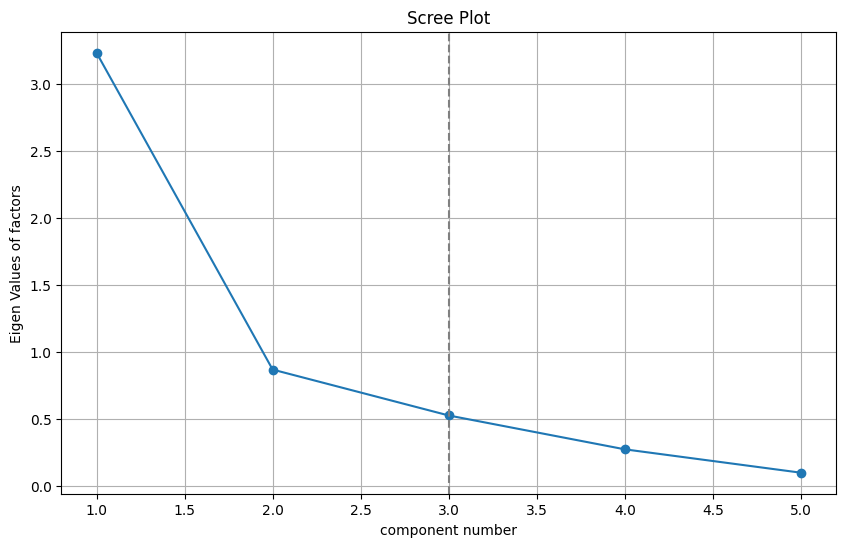

In [41]:
correlation_matrix_aftercommunalities = df_filtered_high_communalities.corr(method='spearman')
fa = FactorAnalyzer(n_factors=df_filtered_high_communalities.shape[1], rotation=None, is_corr_matrix= True)
fa.fit(correlation_matrix_aftercommunalities)

# Obtain the eigenvalues
ev, v = fa.get_eigenvalues()

# scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, correlation_matrix_aftercommunalities.shape[1] + 1), ev, marker='o')
plt.xlabel('component number')
plt.ylabel('Eigen Values of factors')
plt.title('Scree Plot')
plt.axvline(x=3, color='gray', linestyle='--')
plt.grid()
plt.show()

### KMO test after removal of variables with low communalities

In [42]:
kmo_all, kmo_model = calculate_kmo(df_filtered_high_communalities)
print(f"KMO: {kmo_model}")

KMO: 0.7629254784560127


### Second Factor Anlysis with Varimax Rotation

In [43]:
# Factor Analysis with varimax rotation 
fa2 = FactorAnalyzer(n_factors=3, rotation='varimax', method = "minres", is_corr_matrix= True)

#correlation_matrix_afterKMO = df_filtered_afterKMO.corr(method='spearman')
fa2.fit(correlation_matrix_aftercommunalities)

# Obtain loadings
loadings = fa2.loadings_

# Create a Dataframe with the loadings
loadings_df = pd.DataFrame(loadings, columns=[f'Factor{i+1}' for i in range(loadings.shape[1])], index=df_filtered_high_communalities.columns)

print("Loadings:")
print(loadings_df)

Loadings:
                    Factor1   Factor2   Factor3
FmaxVoc            0.368386  0.774706  0.152526
FCC1               0.655241  0.309516  0.084873
FCC4               0.169856  0.115853  0.976078
spectral_centroid  0.865527  0.326910  0.372826
bandwidth          0.679935  0.617087  0.080117


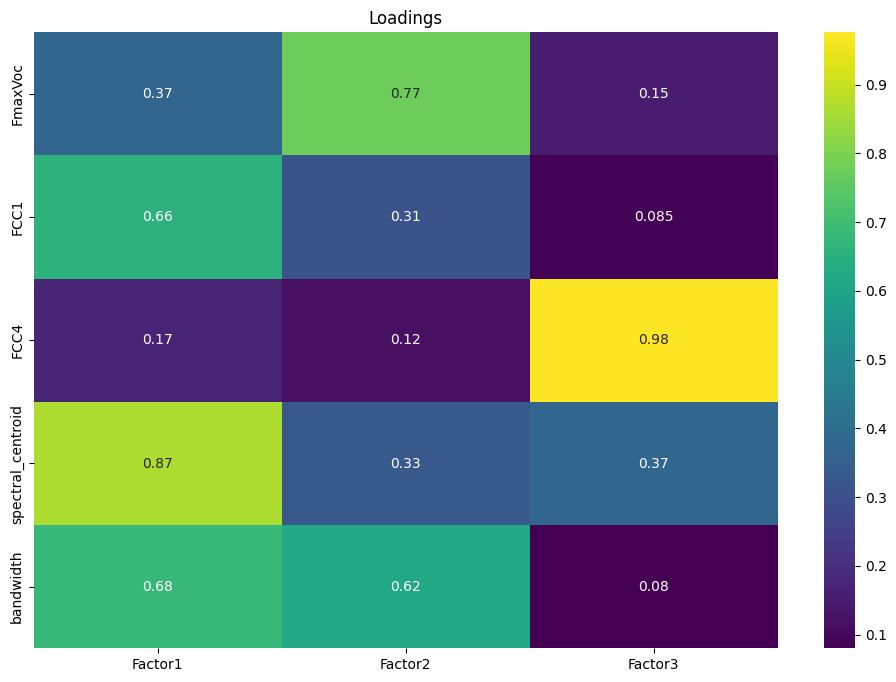

In [45]:
# Ploting the loadings
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_df, annot=True, cmap='viridis')
plt.title('Loadings')
plt.show()

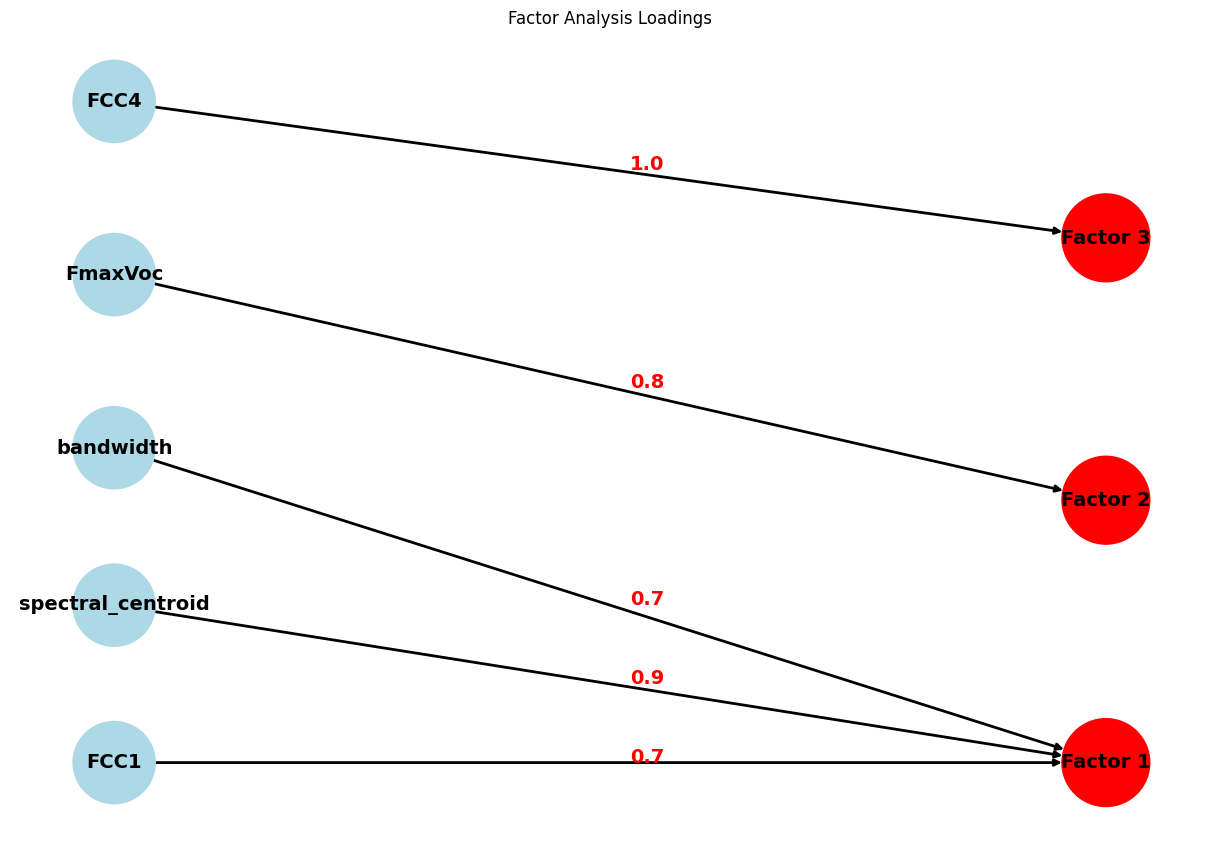

In [46]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_factor_loadings(loadings_df, factor_size=3000, variable_size=2000, font_size=12):
    # Create the graph
    G = nx.DiGraph()

    # Define the spacing between nodes
    space = 1  # Increase the spacing between variables of the same factor
    group_space_multiplier = 0.1  # Further reduce the extra space between different factor groups

    # Create a custom layout
    pos = {}
    y_offset_factors = 0  # Initial y offset for factors
    y_offset_variables = 0  # Initial y offset for variables

    # Assign each variable to the factor with the highest loading
    assignment = {}
    for variable in loadings_df.index:
        max_loading_factor = loadings_df.loc[variable].abs().idxmax()
        max_loading_value = loadings_df.loc[variable, max_loading_factor]
        if abs(max_loading_value) > 0.35:
            assignment[variable] = (max_loading_factor, max_loading_value)

    # Create factor nodes and assign initial positions
    factor_positions = {}
    factor_spacing = len(assignment) * space / len(loadings_df.columns)  # Adjust spacing
    for factor_index, factor in enumerate(loadings_df.columns):
        factor_name = f'Factor {factor_index + 1}'
        G.add_node(factor_name, color='red', size=factor_size)
        factor_positions[factor_name] = y_offset_factors
        pos[factor_name] = (1, y_offset_factors)
        y_offset_factors += factor_spacing

    # Position and add variables to the graph, grouping by factor
    for factor_index, factor in enumerate(loadings_df.columns):
        factor_name = f'Factor {factor_index + 1}'

        # Assign positions to variables assigned to this factor
        for variable, (assigned_factor, weight) in assignment.items():
            if assigned_factor == factor:
                pos[variable] = (0, y_offset_variables)
                G.add_node(variable, color='lightblue', size=variable_size)
                G.add_edge(variable, factor_name, weight=round(weight, 1))
                y_offset_variables += space

        # Add extra space between groups
        y_offset_variables += space * group_space_multiplier

    # Colors and sizes
    node_colors = [nx.get_node_attributes(G, 'color').get(node, 'lightblue') for node in G.nodes()]
    node_sizes = [nx.get_node_attributes(G, 'size').get(node, variable_size) for node in G.nodes()]
    edge_labels = nx.get_edge_attributes(G, 'weight')

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, edge_color='black', width=2, font_size=font_size, font_color='black', font_weight='bold')

    # Edge labels with one decimal place
    for (u, v), weight in edge_labels.items():
        x_pos = (pos[u][0] + pos[v][0]) / 2 + 0.02  # Horizontal adjustment
        y_pos = (pos[u][1] + pos[v][1]) / 2
        plt.text(x_pos, y_pos, f'{weight:.1f}', color='red', fontsize=font_size, fontweight='bold')

    plt.title('Factor Analysis Loadings')
    plt.show()

# Call the function to plot with a custom font size
plot_factor_loadings(loadings_df, factor_size=4000, variable_size=3500, font_size=14)

### Create new dataset only with the latent variables and two other variables.

In [49]:
# Extract the 'bandwidth' variable
bandwidth_df = df_only_features[['bandwidth']]
#spectral_flatness_df = df_only_features[['spectral_flatness']]
Length_df = df_only_features[['Length']]
DeltaFreq_df = df_only_features[['DeltaFreq']]
spectral_centroid_df = df_only_features[['spectral_centroid']] 

# Concatenate the latent variables with 'bandwidth'
df_reduced2 = pd.concat([df_latent, Length_df, DeltaFreq_df], axis=1)

df_reduced2['Specie_ID'] = df_filtered['Specie ID']


print("Combined DataFrame:")
print(df_reduced2.head())

file_path = 'C:/Users/jonat/Desktop/PuertoWilches/MJcodesforCoefficients/reduced_dataframe_FA2.xlsx'
# file = '3_reduced_dataframe_FA2'

df_reduced2.to_excel(file_path, index=True)


Combined DataFrame:
       Factor1   Factor2   Factor3  Length  DeltaFreq Specie_ID
0  2313.651285 -0.810538  1.432301   1.999     2498.8      BOAN
1  2325.262738 -1.609512  1.109231   1.999     2498.0      BOAN
2  2416.875341 -0.602763  1.619106   1.999     2491.2      BOAN
3  2376.631380  0.325938  1.642970   1.999     2490.4      BOAN
4  2374.750540 -1.097416  0.829175   1.999     2487.2      BOAN
